# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To specify a default value for the dictionary entries.
from collections import defaultdict

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# set column names
column_names = ['user_id', 'prod_id', 'rating', 'timestamp']
df = pd.read_csv(
    '/content/drive/MyDrive/Elective Projects - Recommendation System/ratings_Electronics.csv',
    header=None, names = column_names).drop(columns='timestamp')
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape


(65290, 3)

In [ ]:
# find the number of rows being removed from the original data
row_diff = len(df) - len(df_final)
print(f' The difference in the number of rows is: {row_diff}')

 The difference in the number of rows is: 60581


**Write your observations here:______**

The final dataframe has 65290 rows and 3 columns, containing user ID, product ID and rating. The users in the final data have at least 50 ratings to be considered and the items have at least 5 ratings to be considered. A total 60581 entries are removed from the original "df" to reach "df_final".

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:______**

Both user and product ID are objects/strings and the rating is currently stored as float.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Write your observations here:______**

There are no mssing values in the final data.

### **Checking for Duplications**

In [ ]:
# Before removing duplicates
print("Before removing duplicates:", df_final.shape)

# Remove duplicates
df_final_cleaned = df_final.drop_duplicates(keep='first')

print("After removing duplicates:", df_final_cleaned.shape)

Before removing duplicates: (65290, 3)
After removing duplicates: (65290, 3)


The shape remains the same before and after the duplicates drop, indicating there is no duplicate in df_final dataframe. As duplicates may distort the result, it's important to double check on duplication.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Write your observations here:______**

The lowest rating is 1 and the highest rating is 5, while the average is 4.29. Since both the median and the 75th percentile are at 5, this demonstrates a very strong lean towards higher ratings.

### **Checking the rating distribution**

In [ ]:
# Check what's in the rating column
df_final['rating'].unique()

array([5., 1., 3., 4., 2.])

In [ ]:
# Check the how many ratings every rating level has
df_final['rating'].value_counts()

5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: rating, dtype: int64

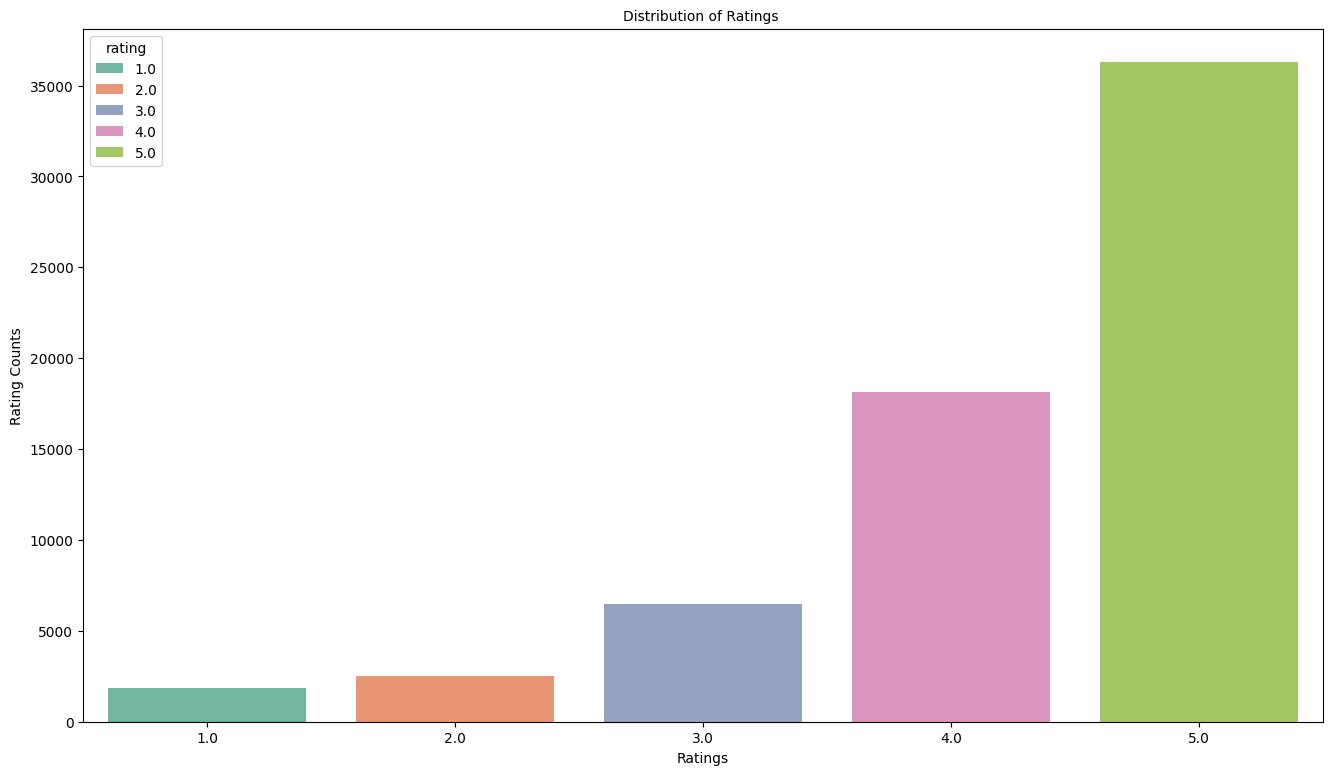

In [ ]:
# Create the bar plot and provide observations
plt.figure(figsize = (16, 9))
sns.countplot(x="rating", data=df_final, hue='rating', palette='Set2')

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Rating Counts", fontsize = 10)
plt.show()

**Write your observations here:________**

As suggested in the .info() result, the most of the ratings are at 5, following by 4. The data distribution is highly left-skewed.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
print('Number of total rows in the data is {}'.format(len(df_final)))
print('Number of unique user ID is {}'.format(df_final['user_id'].nunique()))
print('Number of unique product ID is {}'.format(df_final['prod_id'].nunique()))


Number of total rows in the data is 65290
Number of unique user ID is 1540
Number of unique product ID is 5689


In [ ]:
# Possibility of ratings
print('Number of possible rating combinations: {}'.format(df_final['user_id'].nunique()*df_final['prod_id'].nunique()))

Number of possible rating combinations: 8761060


**Write your observations here:_______**

Number of total rows in the data is 65290

Number of unique user ID is 1540

Number of unique product ID is 5689

Number of possible rating combinations: 8761060

There are 8,761,060 possible ratings based on the number of unique user ID and unique product ID. However, the ratings that are avaiable is only 65,290, indicating that not all the user rates and/or not all the products are rated.


### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
# Group by 'user_id', count 'rating' per user, sort the counts in descending order, and then select the top 10
top_10_users = df_final.groupby('user_id')['rating'].count().sort_values(ascending=False).head(10)

print('Top 10 users based on the number of ratings: {}'.format(top_10_users))

Top 10 users based on the number of ratings: user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
Name: rating, dtype: int64


**Write your observations here:_______**

Top 10 users based on the number of ratings:
         
- ADLVFFE4VBT8:      295
- A3OXHLG6DIBRW8:    230
- A1ODOGXEYECQQ8:    217
- A36K2N527TXXJN:    212
- A25C2M3QF9G7OQ:    203
- A680RUE1FDO8B:     196
- A22CW0ZHY3NJH8:    193
- A1UQBFCERIP7VJ:    193
- AWPODHOB4GFWL:     184
- A3LGT6UZL99IW1:    179

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
avg_count_rating_df = pd.DataFrame({'avg_rating': avg_rating, 'count_rating': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = avg_count_rating_df.sort_values(by='avg_rating', ascending = False)


# See the first five records of the "final_rating" dataset
final_rating.head()


,avg_rating,count_rating
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Sort the 'final_rating' dataframe by count_rating to see the distribution
dist_count_rating = final_rating['count_rating'].sort_values(ascending = False)
dist_count_rating

prod_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B0078J2HS4      5
B000NZVR3Q      5
B002P3KO8I      5
B0087Y1XS4      5
B00LGQ6HL8      5
Name: count_rating, Length: 5689, dtype: int64

In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
# Based on the number of rating counts, it makes sense to set the default min_interaction at 100.
def top_n_prod(data, n, min_interaction=100):

    # Finding products with minimum number of interactions
    recommendations = data[data['count_rating'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
rec1 = list(top_n_prod(final_rating, 5, 50))
rec1

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
rec2 = list(top_n_prod(final_rating, 5, 100))
rec2

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testdata)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
# The rating range is from 1 to 5
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final, reader)

# Splitting the data into train and test dataset
traindata, testdata = train_test_split(data, test_size=0.3, random_state=1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options_user = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
rs_user_user = KNNBasic(sim_options=sim_options_user,verbose=False, random_state=1)

# Fit the model on the training data
rs_user_user.fit(traindata)


# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(rs_user_user)

RMSE: 1.0390
Precision:  0.852
Recall:  0.785
F_1 score:  0.817


**Write your observations here:__________**

RMSE: 1.0390
- An RMSE of 1.0390 suggests that, on average, the model's predictions are about 1.0390 units away from the actual ratings.

Precision:  0.852
- A precision of 0.852 means that 85.2% of the items recommended by the model are relevant to the users.

Recall:  0.785
- A recall of 0.785 indicates that among all the relevant products, 78.5% are recommended.

F_1 score:  0.817
- An F1 score of 0.817 suggests a good balance between precision and recall, indicating that the model is robust in its recommendations, making it quite accurate and comprehensive.


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
rs_user_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.80   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.8, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:__________**

The model has predicted that user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 3.8, which is lower than the actual rating of 5.0. This discrepancy indicates the model might underestimate the user's preference for this product or the product might be particularly appealing to the user but fail to be captured by the model.

Since the actual_k is 5, the prediction was influenced by the ratings of 5 similar users.

'was_impossible' is False indicates that the prediction was made under normal circumstances, meaning the model had enough information to generate the prediction.

To conclude, the difference between the estimated rating and the actual rating suggests there might be room for improvement in the model.

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

['A1TQBAHI3M4ZBQ',
 'A2XCCN239AR1XK',
 'A23E9QQHJLNGUI',
 'AJCR7L4AXL2OG',
 'A3PDWA32BAMB2Y']

* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
rs_user_user.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.34   {'actual_k': 3, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.3355875039423895, details={'actual_k': 3, 'was_impossible': False})

**Write your observations here:__________**

The prediction suggests that, user A2UOHALGF2X77Q is likely to rate 4.34 towards product 1400501466. This is a relatively high rating, indicating that the product might be a good recommendation for this user based on the preferences of a few similar users.

'actual_k = 3' means only 3 neighbors are used to make this prediction, which is quite sparse and 'was_impossible = False' indicates the model didn't encounter any issues that would make a prediction impossible.

This product would likely be considered a strong candidate for this user. However, since the prediction is based on a relatively small number of similar users, it might be better to include other factors or additional recommendations to ensure a better user experience for the recommendation system.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid_user = {'k': [20, 30, 40], 'min_k': [1, 3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs_user = GridSearchCV(KNNBasic, param_grid_user, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs_user.fit(data)

# Best RMSE score
print(gs_user.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_user.best_params['rmse'])

0.9718438598059839
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options_user_opt = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options_user_opt, k=40, min_k=6, verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(traindata)

# Let us compute precision@k and recall@k with k=10.
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9790
Precision:  0.842
Recall:  0.808
F_1 score:  0.825


**Write your observations here:__________**

Before tuning:
- RMSE: 1.0390
- Precision:  0.852
- Recall:  0.785
- F_1 score:  0.817

After tuning:
- RMSE: 0.9790
- Precision:  0.842
- Recall:  0.808
- F_1 score:  0.825

The decrease in RMSE to 0.9790 signifies an improvement in the accuracy of the model's predictions. The predictions are now, on average, about 0.9790 points away from the actual ratings, which is closer than before tuning.

There's a slight decrease in precision to 84.2%, meaning that a slightly lower proportion of recommended items are now relevant to the users compared to before tuning. This decrease is minor but suggests a trade-off was made for improvements in other areas.

The recall has increased to 80.8%, indicating that the system is now able to identify a larger portion of relevant items. This improvement suggests that the tuning helped the system to capture more items that are of interest to users.

The F1 score has increased, reflecting an improved balance between precision and recall. This increase suggests that, overall, the system has become more effective at making relevant recommendations after tuning, even considering the slight decrease in precision.

Overall, the slight decrease in precision is relatively minor compared to the gains in recall and accuracy, resulting in a higher F1 score which indicates a better balance between precision and recall. This implies that the tuning was successful in enhancing the model's overall recommendation quality and relevance.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
# Based on the info above, the user rates the product as 5
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.29674200818327, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_user_user_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.29674200818327, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**____________

By looking at the estimation itself, the model before tuning has predicted that user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 3.8. The tuned model predict that this user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 4.3. The discrepency between the prediction and the actual rating has improved by the tuning.

For user A2UOHALGF2X77Q, the prediction made by the model before tuning suggests that this user is likely to rate 4.34 towards product 1400501466. The tuned model suggests a rating of 4.3. The difference on the estimation is not material.

However, despite the model's attempt to predict a rating of approximately 4.30 for both the user-item pairs, this result should be approached with caution due to the 'was_impossible: True' flag. This indicates that the system couldn't reliably predict the user's rating for the product because it didn't find enough similar users to draw a confident conclusion.








### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, k=5)

[1, 10, 17, 18, 28]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top_5_rec_user = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(top_5_rec_user, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B002WE4HE2,5.000000
1,B002WE6D44,5.000000
2,B0052SCU8U,5.000000
3,B003ES5ZUU,4.951627
4,B000Q8UAWY,4.857143


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options_item = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
rs_item_item = KNNBasic(sim_options=sim_options_item,verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
rs_item_item.fit(traindata)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(rs_item_item)

RMSE: 1.0345
Precision:  0.833
Recall:  0.768
F_1 score:  0.799


**Write your observations here:**____________

RMSE: 1.0345
- An RMSE of 1.0345 means that the model's predictions are, on average, about 1.0345 rating points away from the actual user ratings.

Precision: 0.833
- A precision of 0.833 means that 83.3% of the items recommended by the system are likely to be of interest to the users.

Recall: 0.768
- A recall of 0.768 indicates that the system identifies about 76.8% of all the items that users would find relevant.

F1 Score: 0.799
- An F1 score of 0.799 suggests a good balance between the model's accuracy in its recommendations (precision) and its ability to discover a large portion of the relevant items (recall). It indicates that the system performs well overall, but there is room for improvement in both precision and recall to maximize the system's effectiveness.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
rs_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.19   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.1875, details={'actual_k': 16, 'was_impossible': False})

**Write your observations here:**____________

The model has predicted that user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 4.19, which is lower than the actual rating of 5.0. This discrepancy is lower than the user-user based model before tuning (score 3.8 instead of 5)

Since the actual_k is 16, the prediction was influenced by the ratings of 16 similar products.

"'was_impossible': False" indicates that the prediction was made under normal circumstances, meaning the model had enough information to generate the prediction.

To conclude, the difference between the estimated rating and the actual rating suggests there might be room for improvement in the model.

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
rs_item_item.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.67   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.666666666666667, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here:**____________

The item-item model predicts a high rating of approximately 4.67 for the item 1400501466 by user A2UOHALGF2X77Q. This suggests a strong likelihood that the user would enjoy this product.

'actual_k: 6' indicates the use of 6 similar products.

"'was_impossible': False" indicates that the prediction was made under normal circumstances, meaning the model had enough information to generate the prediction.


### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid_item = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs_item = GridSearchCV(KNNBasic, param_grid_item, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs_item.fit(data)

# Best RMSE score
print(gs_item.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_item.best_params['rmse'])

0.974887966155268
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options_item_opt = {'name': 'msd',
               'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options_item_opt, k=30, min_k=6, verbose=False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(traindata)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)


RMSE: 0.9804
Precision:  0.833
Recall:  0.8
F_1 score:  0.816


**Write your observations here:__________**

Before tuning:
- RMSE: 1.0345
- Precision:  0.833
- Recall:  0.768
- F_1 score:  0.799

After tuning:
- RMSE: 0.9804
- Precision:  0.833
- Recall:  0.8
- F_1 score:  0.816

RMSE: 0.9804 shows an improvement in the accuracy of the model's rating predictions, with the average error reducing to approximately 0.9804 points. This reduction in RMSE indicates that tuning has made the model's predictions closer to the actual user ratings.

Precision: 0.833 remains unchanged, indicating that the tuning process did not affect the proportion of relevant recommendations made by the model. The model continues to recommend items that are likely relevant to the user at the same rate as before. The precision remains unchanged, indicating that the tuning did not compromise the quality of the recommendations as user-user collaborative filtering does.

Recall: 0.8 has increased from 0.768, showing that the model now captures 80% of all relevant items, improving its ability to identify items that users will find relevant.

F1 Score: 0.816 has improved, indicating a better balance between precision and recall. This suggests that the tuning has enhanced the overall effectiveness of the recommendation system by making it more capable of recommending a broader range of relevant items without compromising the accuracy of those recommendations.










### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.53   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.534653465346536, details={'actual_k': 16, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_item_item_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.77   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.774193548387096, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here:__________**

The model before tuning has predicted that user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 4.19. The tuned model predict that this user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 4.53. The discrepency between the prediction and the actual rating has improved by the tuning.

For user A2UOHALGF2X77Q, the prediction made by the model before tuning suggests that this user is likely to rate 4.67 towards product 1400501466. The tuned model suggests a rating of 4.77. This result indicates that the model before tuning might predict the score a little bit lower than the tuned model as the tuned model has better performance.

Unlike the user-user model, item-item model has 'was_impossible = False', indicating that the prediction was made under normal circumstances, meaning the model had enough information to generate the prediction.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k=5)

[9, 12, 13, 22, 28]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
top_5_rec_item = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(top_5_rec_item, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.296742
1,1400599997,4.296742
2,9983891212,4.296742
3,B00000DM9W,4.296742
4,B00000J1V5,4.296742


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(traindata)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9114
Precision:  0.854
Recall:  0.802
F_1 score:  0.827


**Write your observations here:___________**

RMSE: 0.9114
- An RMSE of 0.9114 suggests that the model's predictions are, on average, about 0.9114 rating points away from the actual user ratings.

Precision: 0.854
- A precision of 0.854 means that 85.4% of the items recommended by the model are relevant to the users.

Recall: 0.802
- A recall of 0.802 indicates that the model is able to recommend about 80.2% of the items that are relevant to users.

F1 Score: 0.827
- An F1 score of 0.827 reflects a good balance between the model's precision and recall. It indicates that the model performs well overall in making relevant recommendations to users, effectively balancing the trade-off between the quality of recommendations and the coverage of relevant items.







**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.262585198727372, details={'was_impossible': False})

**Write your observations here:___________**

The svd model has predicted that user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 4.26, which is lower than the actual rating of 5.0. However, the result is better than the user-user and item-item collaborative filtering system. The discrepancy of the estimation from the actual rating using SVD is lower than the user-user (estimates 3.8) and item-item (estimates 4.19) collaborative filtering system.

'was_impossible' is False indicates that the prediction was made under normal circumstances, meaning the model had enough information to generate the prediction.

To conclude, the difference between the estimated rating and the actual rating suggests there might be room for improvement in the model.


**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A2UOHALGF2X77Q", "1400501466", verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.03   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.0319555800920455, details={'was_impossible': False})

**Write your observations here:___________**

The SVD model prediction suggests that user A2UOHALGF2X77Q is likely to rate 4.03 towards product 1400501466. This estimation score is lower than the result from user-user (estimates 4.34) and item-item (estimates 4.67) collaborative filtering system. 4.03 is still considered relatively high score, indicating the product might be a good recommendation for this user.

'was_impossible' is False indicates that the prediction was made under normal circumstances, meaning the model had enough information to generate the prediction.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid_svd = {'n_epochs': [5, 10, 20, 30], 'lr_all': [0.005, 0.01, 0.02],
              'reg_all': [0.1, 0.15, 0.4]}

# Performing 3-fold gridsearch cross validation
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])

0.8986764055126791
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Train the algorithm on the trainset
svd_algo_optimized.fit(traindata)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.9043
Precision:  0.855
Recall:  0.804
F_1 score:  0.829




Before tuning:
- RMSE: 0.9114
- Precision: 0.854
- Recall: 0.802
- F_1 score: 0.827

After tuning:
- RMSE: 0.9043
- Precision:  0.855
- Recall:  0.804
- F_1 score:  0.829

RMSE: 0.9043 shows a slight improvement in prediction accuracy, with a small decrease in the average error to about 0.9043 points away from actual ratings. This improvement indicates that tuning has made the model slightly better at predicting how users rate products.

Precision: 0.855 has marginally increased, indicating that 85.5% of the recommendations made by the model are now relevant. This slight improvement suggests that tuning has enhanced the model's ability to identify items that users will likely appreciate.

Recall: 0.804 has also improved slightly, indicating that the model is now able to capture about 80.4% of all relevant items.

F1 Score: 0.829 has increased marginally, reflecting the slight improvements in both precision and recall. This suggests that tuning has enhanced the model's overall balance between making accurate recommendations and identifying a broad range of relevant items.

The tuning of the SVD model has resulted in slight improvements across all metrics. These improvements are positive signs that the tuning process has moved the model in the right direction. However, given the marginal nature of these improvements, further tuning and exploration of hyperparameters might yield even better results.







### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_algo_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.11   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.108578805446343, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
svd_algo_optimized.predict("A2UOHALGF2X77Q", "1400501466", verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.03   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.0280629621326405, details={'was_impossible': False})

The model before tuning has predicted that user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 4.26. The tuned model predict that this user A3LDPF5FMB782Z would rate the product 1400501466 with a score of 4.11. This discrepency increase after tuning indicates that while tuning has improved the SVD model's overall performance, individual predictions may not uniformly reflect these improvements.

For user A2UOHALGF2X77Q, the prediction made by the model before tuning suggests that this user is likely to rate 4.03 towards product 1400501466. The tuned model suggests a rating of 4.03. It's likely that 4 would be the rating this user would give to the product.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

3 models are used in the study,
 1. rank-based
 2. collaborative filtering
 3. matrix factorization (svd)

The first model simply uses the popularity, which is a good one to solve cold start problems.

The performance of the rest of the systems is as the following:

User-user collaborative filtering:
- Before tuning:
  - RMSE: 1.0390
  - Precision:  0.852
  - Recall:  0.785
  - F_1 score:  0.817

- After tuning:
  - RMSE: 0.9790
  - Precision:  0.842
  - Recall:  0.808
  - F_1 score:  0.825


Item-item collaborative filtering:
- Before tuning:
  - RMSE: 1.0345
  - Precision:  0.833
  - Recall:  0.768
  - F_1 score:  0.799

- After tuning:
  - RMSE: 0.9804
  - Precision:  0.833
  - Recall:  0.8
  - F_1 score:  0.816

SVD
- Before tuning:
  - RMSE: 0.9114
  - Precision: 0.854
  - Recall: 0.802
  - F_1 score: 0.827

- After tuning:
  - RMSE: 0.9043
  - Precision:  0.855
  - Recall:  0.804
  - F_1 score:  0.829



For the user-user collaborative filtering model, tuning resulted in a notable decrease in RMSE, indicating enhanced accuracy in rating predictions. Although precision slightly decreased, recall and the F1 score improved, suggesting the tuned model is better at identifying a broader range of relevant products for users.

The item-item collaborative filtering model showed similar trends, with a significant reduction in RMSE and improvements in recall and the F1 score, maintaining precision. This indicates an overall enhancement in the model's ability to predict ratings accurately and recommend relevant items, with a particular improvement in capturing more relevant products to users.

The SVD model also exhibited improvements across all metrics, with a decrease in RMSE and slight increases in precision, recall, and the F1 score. This indicates that the tuning process has made the SVD model slightly more accurate in predicting user ratings and slightly better at balancing the precision and recall of its recommendations.

**Recommendation**:

1. Depending on the situation, there are two possible models to choose:

  a. Optimized User-User Collaborative Filtering: With high recall, it's suitable when the goal is to expose customers to a broader selection of products. By doing so can help diversify the customer experience and potentially increase cross-category sales.

  b. Optimized SVD: This model is slightly more accurate at predicting which products a customer will like based on their past behavior. It's suitable when the goal is to minimize the risk of recommending uninteresting items in order to enhance customer satisfaction and loyalty.
  
  It's more likely that the focus will be on getting customer exposed to broader product selections for Amazon. Thus, optimized user-user collaborative filtering model should be used on the recommendation system if it's required to only pick one.

2. Exploring additional hyperparameters, experimenting with different tuning methods, and incorporating more sophisticated models (like neural networks or ensemble methods) could be ways to get better results.

3. Hybrid models that combine the strengths of collaborative filtering and matrix factorization techniques may also be another way to improve the recommendation system.






